<a href="https://colab.research.google.com/github/tahaerdem/faultlines/blob/main/071224%20-%20FaultLines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ipython-autotime
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.8 MB/s eta 0:00:00
time: 244 µs (started: 2024-04-19 23:40:23 +00:00)


# 1. Install deep learning libraries.
This usually takes less than 5 minutes on A100. Hit restart session before running the next code, and run it again.

In [ ]:
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

!pip install torch torchvision
!pip install transformers
!pip install groundingdino
!pip install matplotlib pillow
!pip install -U git+https://github.com/luca-medeiros/lang-segment-anything.git

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

time: 3min 17s (started: 2024-04-19 23:40:32 +00:00)


#2. Import required Python libraries.

In [ ]:
import os
import warnings
import json
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize
from PIL import Image, ImageOps, ImageDraw
from lang_sam import LangSAM
import cv2
import torch

#3. Check GPU availability and set the device for CUDA.
No need to do it if connected to A100 or V100 - or running this notebook on Jupyter or Colab.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


#4. Load SAM and DINO models.

In [ ]:
model = LangSAM()

final text_encoder_type: bert-base-uncased
Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


#5. Define functions.

In [ ]:
def split_image(image):
    width, height = image.size
    left_half = image.crop((0, 0, width // 2, height))
    right_half = image.crop((width // 2, 0, width, height))
    return left_half, right_half

def save_mask(mask_np, filename):
    mask_image = Image.fromarray((mask_np * 255).astype(np.uint8))
    mask_image.save(filename)

def save_maskgraph(image_path, maskgraph_save_path):
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    maskgraph_filename = f"{base_name}_maskgraph.png"
    full_path = os.path.join(maskgraph_save_path, maskgraph_filename)
    plt.savefig(full_path)  # Save the plot before displaying it
    print(f"Saved maskgraph as {maskgraph_filename}")
    return full_path

def save_overlaygraph(image_path, overlaygraph_save_path):
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    overlaygraph_filename = f"{base_name}_overlayraph.png"
    full_path = os.path.join(overlaygraph_save_path, overlaygraph_filename)
    plt.savefig(full_path)  # Save the plot before displaying it
    print(f"Saved overlaygraph as {overlaygraph_filename}")
    return full_path

def display_image_with_masks(image, image_path, left_masks, right_masks):
    num_left_masks = len(left_masks)
    num_right_masks = len(right_masks)
    max_masks = max(num_left_masks, num_right_masks)

    # Create a subplot grid with 2 rows and enough columns
    fig, axes = plt.subplots(2, max_masks + 1, figsize=(15, 10))

    # Plot the original image in the first column of each row
    axes[0, 0].imshow(image)
    axes[0, 0].set_title("Original Image")
    axes[0, 0].axis('off')
    axes[1, 0].axis('off')  # Ensure the corresponding subplot in the second row is turned off

    # Display left masks, if any
    if len(left_masks) != 0:
        for i in range(num_left_masks):
            axes[0, i + 1].imshow(left_masks[i], cmap='Blues')
            axes[0, i + 1].set_title(f"L {i + 1}")
            axes[0, i + 1].axis('off')

    # Display right masks, if any
    if len(right_masks) != 0:
        for i in range(num_right_masks):
            axes[1, i + 1].imshow(right_masks[i], cmap='Reds')
            axes[1, i + 1].set_title(f"R {i + 1}")
            axes[1, i + 1].axis('off')

    # Turn off any unused axes
    for i in range(max_masks):
        if i >= num_left_masks:
            axes[0, i + 1].axis('off')
        if i >= num_right_masks:
            axes[1, i + 1].axis('off')

    # Save the figure before showing it
    maskgraph_save_path = "/content/drive/MyDrive/FaultLines/svi/40187_size300x800_fov120/rectified/maskgraphs/"
    save_maskgraph(image_path, maskgraph_save_path)

    plt.tight_layout()
    plt.show()
    plt.close()

def display_image_with_boxes(image, image_path, left_boxes, right_boxes, left_logits, right_logits):
    combined_boxes = [(box, 'left') for box in left_boxes] + [(box, 'right') for box in right_boxes]
    centerline = image.size[0] // 2
    plotline = image.size[1] // 2.75
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.set_title("Image with Bounding Boxes")
    ax.axis('off')

    centroidsL = [] #Left side window centroids.
    centroidsR = [] #Right side window centroids.

    tolerance = 10 #Adjust the tolerance by pixel.

    ccL = [] #Closest left window centroid to the adjacency line.
    ccR = [] #Closest right window centroid to the adjacency line.

    lW = []
    rW = []

    rowR = []
    rowL = []

    for box, logit in zip(left_boxes, left_logits):
        x_min, y_min, x_max, y_max = box
        box_width = x_max - x_min
        box_height = y_max - y_min
        centroid_x, centroid_y = (x_min + x_max) / 2, (y_min + y_max) / 2
        centroidsL.append((centroid_x, centroid_y))
        rect = plt.Rectangle((x_min, y_min), box_width, box_height, fill=False, edgecolor='blue', linewidth=1)
        ax.plot(centroid_x, centroid_y, 'o', color='blue', markersize=3)
        ax.add_patch(rect)

    for box, logit in zip(right_boxes, right_logits):
        x_min, y_min, x_max, y_max = box
        x_min += centerline
        x_max += centerline
        box_width = x_max - x_min
        box_height = y_max - y_min
        centroid_x, centroid_y = (x_min + x_max) / 2, (y_min + y_max) / 2
        centroidsR.append((centroid_x, centroid_y))
        rect = plt.Rectangle((x_min, y_min), box_width, box_height, fill=False, edgecolor='red', linewidth=1)
        ax.plot(centroid_x, centroid_y, 'o', color='red', markersize=3)
        ax.add_patch(rect)

    ccL = min(centroidsL, key=lambda c: abs(c[0] - centerline)) if centroidsL else None
    if ccL:
        ax.axvline(ccL[0], color='blue', linestyle='--')

    ccR = min(centroidsR, key=lambda c: abs(c[0] - centerline)) if centroidsR else None
    if ccR:
        ax.axvline(ccR[0], color='red', linestyle='--')

    for box, logit in zip(left_boxes, left_logits):
        x_min, y_min, x_max, y_max = box
        x_min_tol = x_min - tolerance
        x_max_tol = x_max + tolerance
        centroid_x, centroid_y = (x_min + x_max) / 2, (y_min + y_max) / 2
        if x_min_tol <= ccL[0] <= x_max_tol:
            rowL.append((x_min, y_min, x_max - x_min, y_max - y_min, centroid_x, centroid_y, (centroid_y - plotline)))
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, fill=False, edgecolor='lime', linewidth=5)
            ax.add_patch(rect)

    for box, logit in zip(right_boxes, right_logits):
        x_min, y_min, x_max, y_max = box
        x_min_tol = x_min - tolerance
        x_max_tol = x_max + tolerance
        centroid_x, centroid_y = (x_min + x_max) / 2, (y_min + y_max) / 2
        if x_min <= ccR[0] <= x_max:
            rowR.append((x_min, y_min, x_max - x_min, y_max - y_min, centroid_x, centroid_y, (centroid_y - plotline)))
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, fill=False, edgecolor='lime', linewidth=5)
            ax.add_patch(rect)

    left_windows = sorted(rowL, key=lambda c: c[5], reverse=True) #Sort windows by y value of the centroid.
    right_windows = sorted(rowR, key=lambda c: c[5], reverse=True) #Sort windows by y value of the centroid.

    lwIndex = [(window[0], window[1], window[2], window[3], window[4], window[5], window[6], f'L{i+1}') for i, window in enumerate(left_windows)] #Index each window by direction and floor number.
    rwIndex = [(window[0], window[1], window[2], window[3], window[4], window[5], window[6], f'R{i+1}') for i, window in enumerate(right_windows)] #Index each window by direction and floor number.

    for window in lwIndex:
        ax.text(window[4], window[5], window[7], color='black', fontsize=8, ha='center', va='center')

    for window in rwIndex:
        ax.text(window[4], window[5], window[7], color='black', fontsize=8, ha='center', va='center')

    lwIndex_sorted_by_distance = sorted(lwIndex, key=lambda w: abs(w[6]))
    rwIndex_sorted_by_distance = sorted(rwIndex, key=lambda w: abs(w[6]))
    two_closest_lw = lwIndex_sorted_by_distance[:2]
    two_closest_rw = rwIndex_sorted_by_distance[:2]

    for window in lwIndex_sorted_by_distance[:2]:
        rect = plt.Rectangle((window[0], window[1]), window[2], window[3], fill=False, edgecolor='yellow', linewidth=10)
        ax.axhline(window[5], color='yellow', linestyle='--')
        ax.add_patch(rect)

    for window in rwIndex_sorted_by_distance[:2]:
        rect = plt.Rectangle((window[0], window[1]), window[2], window[3], fill=False, edgecolor='yellow', linewidth=10)
        ax.axhline(window[5], color='yellow', linestyle='--')
        ax.add_patch(rect)

    def draw_lines_and_get_midpoints(left_closest_windows, right_closest_windows, color, ax, centerline):
      midpoints = []
      vdist = []
      yfactor = []

      for closest_windows in [left_closest_windows, right_closest_windows]:
          if len(closest_windows) == 2:  # Ensure there are at least two windows to connect.
              centroid1 = (closest_windows[0][4], closest_windows[0][5])
              centroid2 = (closest_windows[1][4], closest_windows[1][5])

              vdist_ind = abs(closest_windows[0][5] - closest_windows[1][5]) / 2
              vdist.append(vdist_ind)

              ax.plot([centroid1[0], centroid2[0]], [centroid1[1], centroid2[1]], color=color)

              midpoint_x = (centroid1[0] + centroid2[0]) / 2
              midpoint_y = (centroid1[1] + centroid2[1]) / 2

              for higher_midpoint in [midpoint_x, midpoint_y]:
                  sorted(rowL, key=lambda c: c[5], reverse=True)

              ax.plot(midpoint_x, midpoint_y, 'o', color=color, markersize=10)
              midpoints.append((midpoint_x, midpoint_y))
          else:
              print("Not enough windows found to make a prediction.")

          # Ensure you have two midpoints before calculating the distance between them
          if len(midpoints) == 2:
              yfactor = int((vdist[0] + vdist[1]) / 4)
              mdist = abs(midpoints[0][1] - midpoints[1][1])
              mcalc = yfactor / mdist

              calc_save_path = "/content/drive/MyDrive/FaultLines/svi/40187_size300x800_fov120/rectified/calc/"

              def save_calc(image_path, calc_save_path, mcalc):
                  base_name = os.path.splitext(os.path.basename(image_path))[0]
                  calc_filename = f"{base_name}_{mcalc}.png"
                  print(calc_filename)  # This will print the filename to debug
                  full_path = os.path.join(calc_save_path, calc_filename)
                  plt.savefig(full_path)

              if mcalc >= 0.75:
                  ax.plot([centerline, centerline], [midpoints[0][1], midpoints[1][1]], color='green', markersize=10)
                  print(mcalc)
              elif mcalc > 0.50:
                  ax.plot([centerline, centerline], [midpoints[0][1], midpoints[1][1]], color='orange', markersize=10)
                  print(mcalc)
              elif mcalc > 0.33:
                  ax.plot([centerline, centerline], [midpoints[0][1], midpoints[1][1]], color='yellow', markersize=10)
                  print(mcalc)
              elif mcalc < 0.33:
                  ax.plot([centerline, centerline], [midpoints[0][1], midpoints[1][1]], color='red', markersize=10)
                  print(mcalc)
              else:
                  mcalc = "NULL"

              save_calc(image_path, calc_save_path, mcalc)
              return mcalc

    draw_lines_and_get_midpoints(two_closest_lw, two_closest_rw, 'red', ax, centerline)
    plt.show()

def save_overlayed_masks(image, filename, left_masks, right_masks):
    # Create a new directory called 'processed' within the source folder if it doesn't exist
    base_folder = os.path.dirname(filename)
    processed_folder = os.path.join(base_folder, "processed")
    os.makedirs(processed_folder, exist_ok=True)

    # Extract the base name and extension of the filename
    base_name = os.path.basename(filename)
    name, extension = os.path.splitext(base_name)
    combined_filename = f"{name}_combined{extension}"
    processed_filepath = os.path.join(processed_folder, combined_filename)

    full_overlay = Image.new("RGBA", image.size, (0, 0, 0, 0))

    # Process left masks
    for mask in left_masks:
        mask_image = Image.fromarray((mask * 255).astype('uint8'))
        mask_rgba = ImageOps.colorize(mask_image.convert('L'), (0, 0, 255), (0, 0, 255))
        mask_rgba.putalpha(Image.fromarray((mask * 200).astype('uint8')))  # Apply transparency

        full_overlay.paste(mask_rgba, (0, 0), mask_rgba)

    # Process right masks
    for mask in right_masks:
        mask_image = Image.fromarray((mask * 255).astype('uint8'))
        mask_rgba = ImageOps.colorize(mask_image.convert('L'), (255, 0, 0), (255, 0, 0))
        mask_rgba.putalpha(Image.fromarray((mask * 200).astype('uint8')))  # Apply transparency
        right_offset = (image.size[0] - mask_rgba.size[0], 0)

        full_overlay.paste(mask_rgba, right_offset, mask_rgba)

    # Display the original image with overlays
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(image)
    ax.set_title("Masks")
    ax.axis('off')

    # Overlay the combined masks on top of the original image
    combined = Image.alpha_composite(image.convert("RGBA"), full_overlay)
    combined.save(processed_filepath)

    ax.imshow(combined)
    plt.show()

def overlaygraph(image, image_path, left_masks, right_masks):
    image_width, image_height = image.size

    # Create a full-width overlay
    full_overlay = np.zeros((image_height, image_width, 4))

    # Draw on the overlay using PIL for centroids
    draw = ImageDraw.Draw(Image.fromarray((full_overlay * 255).astype('uint8'), 'RGBA'))

    # Helper function to draw and return centroids
    def process_masks(masks, overlay, color, draw):
        centroids = []
        for mask in masks:
            mask_height, mask_width = mask.shape
            mask_overlay = np.zeros((image_height, mask_width, 4))
            mask_overlay[mask > 0, :3] = color[:3]  # Color for masks
            mask_overlay[mask > 0, 3] = color[3]  # Transparency

            # Calculate the centroid for the current mask
            y_indices, x_indices = np.where(mask > 0)
            centroid_x = int(x_indices.mean())
            centroid_y = int(y_indices.mean())
            centroids.append((centroid_x, centroid_y))

            # Draw the centroid for the current mask
            draw.ellipse((centroid_x - 3, centroid_y - 3, centroid_x + 3, centroid_y + 3), fill=tuple(color[:3]))

            # Combine the current mask with the overall overlay
            overlay = np.maximum(overlay, mask_overlay)

        return overlay, centroids

    # Process left masks
    full_overlay[:, :image_width // 2], left_centroids = process_masks(left_masks, full_overlay[:, :image_width // 2], [0, 0, 1, 0.5], draw)

    # Process right masks
    full_overlay[:, image_width // 2:], right_centroids = process_masks(right_masks, full_overlay[:, image_width // 2:], [1, 0, 0, 0.5], draw)

    # Display the original image with overlays
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(image)
    ax.set_title("Combined Masks with Centroids")
    ax.axis('off')
    ax.imshow(full_overlay, interpolation='nearest')

    overlaygraph_save_path = "/content/drive/MyDrive/FaultLines/svi/40187_size300x800_fov120/rectified/overlaygraphs/"
    save_overlaygraph(image_path, overlaygraph_save_path)

    plt.show()

    return left_centroids, right_centroids

def mask_polygon_detection(image, image_path, left_masks, right_masks):
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(image)
    ax.set_title("Detected Polygon Corners")
    ax.axis('off')
    cornerico = []

    def find_and_plot_corners(mask, color, offset=(0, 0), mask_side=""):

        polygons = []

        if isinstance(mask, torch.Tensor):
            mask = mask.cpu().numpy()
        mask_uint8 = (mask * 255).astype(np.uint8)
        contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for cnt in contours:
            epsilon = 0.05 * cv2.arcLength(cnt, True)
            approx = cv2.approxPolyDP(cnt, epsilon, True)

            if len(approx) == 4:
                corners = [corner.ravel() + np.array(offset) for corner in approx]

#               print(f"{mask_side} Mask Approximated Corners: {corners}")
                for corner in corners:
                    cornerico.append((corner[0], corner[1]))
                    ax.plot(corner[0], corner[1], marker='o', markersize=3, color=color)

                centroid = np.mean(corners, axis=0)
                ax.plot(centroid[0], centroid[1], marker='x', markersize=7, color=color)
#               print(f"{mask_side} Mask Centroid: {centroid}")

        return polygons

    # Process left masks
    for i, mask in enumerate(left_masks):
        find_and_plot_corners(mask, color='blue', mask_side=f"Left {i+1}")

    # Process right masks
    for i, mask in enumerate(right_masks):
        right_offset = (image.size[0] - mask.shape[1], 0)
        find_and_plot_corners(mask, color='red', offset=right_offset, mask_side=f"Right {i+1}")

    poly_save_path = "/content/drive/MyDrive/FaultLines/svi/40187_size300x800_fov120/rectified/polygons/"

    def save_polygon_images(image_path, poly_save_path):

        base_name = os.path.splitext(os.path.basename(image_path))[0]

        poly_filename = f"{base_name}_POLY.png"
        full_path = os.path.join(poly_save_path, poly_filename)
        plt.savefig(full_path)

    save_polygon_images(image_path, poly_save_path)
    plt.close()

    print(cornerico[0:4])

    def warp_image(image_path, cornerico):
        img = cv2.imread(image_path)
        original_size = (img.shape[1], img.shape[0])
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        b1, d1, ch = img_rgb.shape

        pts1 = np.float32([cornerico[0], cornerico[3], cornerico[2], cornerico[1]])
        print(pts1)
        b1= int(abs(((pts1[0][0] + pts1[3][0])/2)-((pts1[1][0] + pts1[2][0])/2)))
        d1= int(abs(pts1[0][1] - pts1[3][1]))


        pts2 = np.float32([[0, 0],[b1, 0],[b1, d1],[0, d1]])

        M = cv2.getPerspectiveTransform(pts1, pts2)
        #dst = cv2.warpPerspective(img_rgb, M, (b1, d1))

        original_height, original_width = img.shape[:2]

        # Calculate the translation needed to keep cornerico[0] at its original position
        translation_x = cornerico[0][0]
        translation_y = cornerico[0][1]

        # Create a translation matrix
        translation_matrix = np.array([
            [1, 0, translation_x],
            [0, 1, translation_y],
            [0, 0, 1]
        ], dtype=np.float32)

        # Update the transformation matrix M to include the translation
        M = np.dot(translation_matrix, M)

        # Define the new size, which is twice the original width and height
        # The size should be large enough to accommodate the translation
        new_width = original_width + int(translation_x)
        new_height = original_height + int(translation_y)
        new_size = (new_width, new_height)

        # Warp the image using the updated transformation matrix M and the new size
        #dst = cv2.warpPerspective(img_rgb, M, new_size)

        dst = cv2.warpPerspective(img_rgb, M, (original_width, original_height))

        # After the perspective transformation, calculate the new coordinates of the centerline
        transformed_center_x = (cornerico[0][0] + cornerico[1][0]) / 2
        transformed_center_y = (cornerico[0][1] + cornerico[2][1]) / 2

        # Calculate the shift needed to re-center the centerline
        shift_x = original_width / 2 - transformed_center_x
        shift_y = original_height / 2 - transformed_center_y

        # Create a translation matrix to shift the image to re-center the centerline
        translation_matrix = np.array([
            [1, 0, shift_x],
            [0, 1, shift_y],
            [0, 0, 1]
        ], dtype=np.float32)

        M_combined = np.dot(translation_matrix, M)

        original_corners = np.float32([
            [0, 0],
            [original_width - 1, 0],
            [original_width - 1, original_height - 1],
            [0, original_height - 1]
        ]).reshape(-1, 1, 2)
        transformed_corners = cv2.perspectiveTransform(original_corners, M_combined)

        x_min, y_min = np.int0(transformed_corners.min(axis=0).ravel() - 0.5)
        x_max, y_max = np.int0(transformed_corners.max(axis=0).ravel() + 0.5)

        bounding_box = (x_min, y_min, x_max, y_max)
        absxbox = (abs(x_min)+abs(x_max))
        absybox = (abs(y_min)+abs(y_max))

        print(bounding_box)

        new_size = (original_width, original_height)
        dst_combined = cv2.warpPerspective(img_rgb, M_combined, new_size)
        cropped_image = dst_combined[y_min:absybox, x_min:absxbox]

        save_path = "/content/drive/MyDrive/FaultLines/svi/40187_size300x800_fov120/rectified/"

        def save_rectified_images(image_path, dst_combined, cropped_image, save_path):
            base_name = os.path.splitext(os.path.basename(image_path))[0]

            rectified_filename = f"{base_name}_RECTIFIED.png"
            cropped_filename = f"{base_name}_RECTIFIED_CROPPED.png"

            rectified_path = os.path.join(save_path, rectified_filename)
            cropped_path = os.path.join(save_path, cropped_filename)

            cv2.imwrite(rectified_path, cv2.cvtColor(dst_combined, cv2.COLOR_RGB2BGR))
            cv2.imwrite(cropped_path, cv2.cvtColor(cropped_image, cv2.COLOR_RGB2BGR))

        save_rectified_images(image_path, dst_combined, cropped_image, save_path)

        # Plotting the images
        plt.figure(figsize=(16, 8))
        plt.subplot(121)
        plt.imshow(img_rgb)
        plt.title('Original Image')
        plt.subplot(122)
        plt.imshow(cropped_image)
        plt.title('Perspective Corrected Image')
        plt.show()

    #warp_image(image_path, cornerico)

    plt.show()
    return cornerico



#6. Define image segmentation function.

In [ ]:
def process_image(image_path, text_prompt, model):
    try:
        image_pil = Image.open(image_path).convert("RGB")
        image_size = image_pil.size
        left_half, right_half = split_image(image_pil)
        left_masks, left_boxes, left_phrases, left_logits = model.predict(left_half, text_prompt)
        right_masks, right_boxes, right_phrases, right_logits = model.predict(right_half, text_prompt)

        if len(left_masks) == 0 or len(right_masks) == 0:
            print(f"No objects of the '{text_prompt}' prompt detected in either half of the image.")
        else:
            left_masks_np = [mask.squeeze().cpu().numpy() for mask in left_masks]
            right_masks_np = [mask.squeeze().cpu().numpy() for mask in right_masks]

            # Display the images with masks
#            display_image_with_masks(image_pil, image_path, left_masks_np, right_masks_np)
            overlaygraph(image_pil, image_path, left_masks_np, right_masks_np)

        if len(left_masks) == 0:
            print(f"No objects of the '{text_prompt}' prompt detected in the left half of the image.")
        else:
            left_masks_np = [mask.squeeze().cpu().numpy() for mask in left_masks]
#            for i, mask_np in enumerate(left_masks_np):
#                mask_path = f"/content/drive/MyDrive/FaultLines/source/8/left_mask_bw_{i+1}.png"
#                save_mask(mask_np, mask_path)

        if len(right_masks) == 0:
            print(f"No objects of the '{text_prompt}' prompt detected in the right half of the image.")
        else:
            right_masks_np = [mask.squeeze().cpu().numpy() for mask in right_masks]
#            for i, mask_np in enumerate(right_masks_np):
#                mask_path = f"/content/drive/MyDrive/FaultLines/source/8/right_mask_bw_{i+1}.png"
#                save_mask(mask_np, mask_path)

#        display_image_with_masks(image_pil, image_path, left_masks_np, right_masks_np)
#        display_combined_masks(image_pil, image_path, left_masks_np, right_masks_np)
#        save_overlayed_masks(image_pil, left_masks_np, right_masks_np)
#        display_image_with_boxes(image_pil, image_path, left_boxes, right_boxes, left_logits, right_logits)
#        display_masks_for_each_side(image_pil, left_masks, right_masks)
#        mask_polygon_detection(image_pil, image_path, left_masks, right_masks)

#        pwarp(image_path)

    except IOError as e:
        print(f"Error processing image {image_path}: {e}")

#7. Define main model, and add image paths.

In [ ]:
def main(model):
    # Suppress warning messages
    warnings.filterwarnings("ignore")

    text_prompt = "window"

    folder_path = "/content/drive/MyDrive/FaultLines/svi/40187_size300x800_fov120/rectified/"

    # List all files and filter by certain image filetypes for processing.
    all_files = os.listdir(folder_path)
    image_extensions = ['.png', '.jpg', '.jpeg']
    image_paths = [os.path.join(folder_path, file) for file in all_files if os.path.splitext(file)[1].lower() in image_extensions]

    for image_path in image_paths:
        process_image(image_path, text_prompt, model)

#8. Run.

Error processing image /content/drive/MyDrive/FaultLines/svi/40187_size300x800_fov120/rectified/SVI-200-zeCUGEq5tACSWNdiUnerIw-40.99894-28.84055-40187RES4335-40187RES4319_RECTIFIED.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/FaultLines/svi/40187_size300x800_fov120/rectified/overlaygraphs/SVI-200-zeCUGEq5tACSWNdiUnerIw-40.99894-28.84055-40187RES4335-40187RES4319_RECTIFIED_overlayraph.png'
Error processing image /content/drive/MyDrive/FaultLines/svi/40187_size300x800_fov120/rectified/SVI-199-2tHc1TyqwSZlMPUxN_ejGQ-40.9988-28.84056-40187RES4304-40187RES4335_RECTIFIED.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/FaultLines/svi/40187_size300x800_fov120/rectified/overlaygraphs/SVI-199-2tHc1TyqwSZlMPUxN_ejGQ-40.9988-28.84056-40187RES4304-40187RES4335_RECTIFIED_overlayraph.png'
Error processing image /content/drive/MyDrive/FaultLines/svi/40187_size300x800_fov120/rectified/SVI-199-2tHc1TyqwSZlMPUxN_ejGQ-40.9988-28.84056-40187RES4304-40187RES4335 2_RECT

KeyboardInterrupt: 

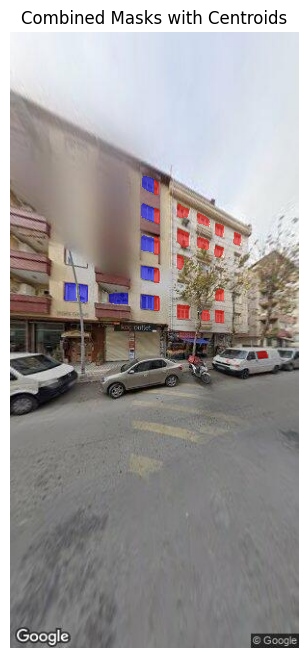

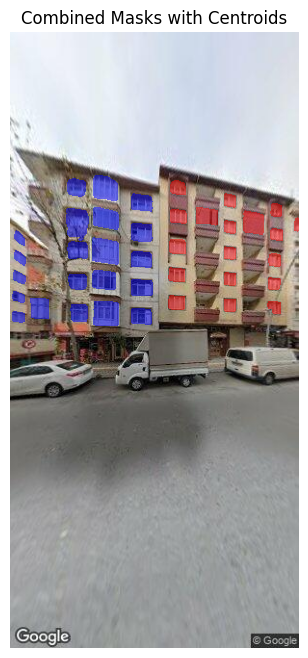

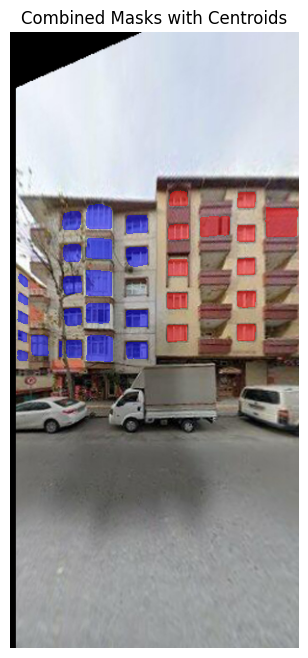

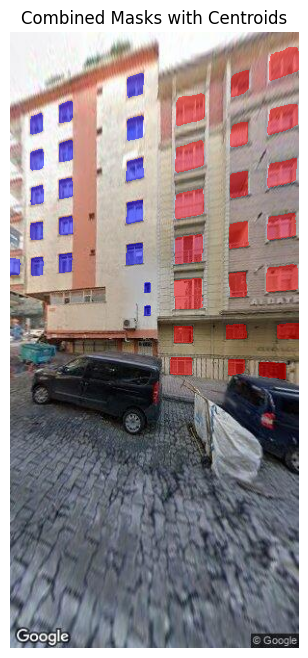

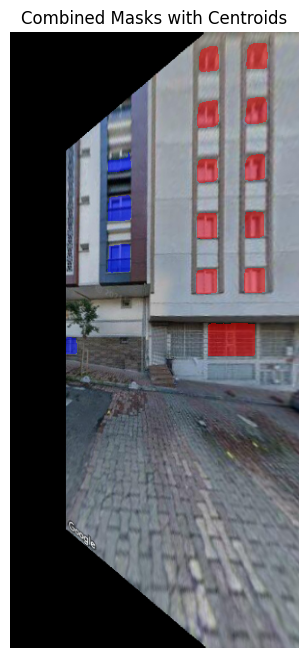

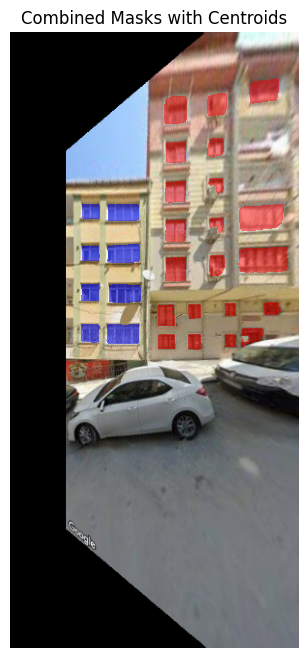

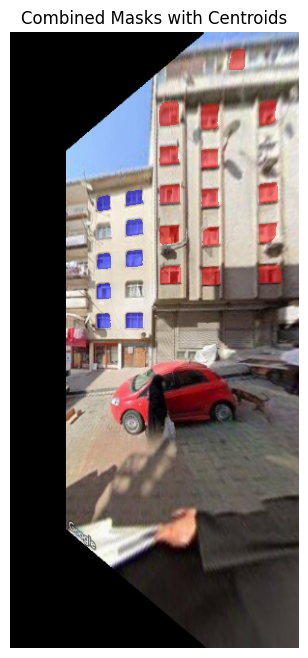

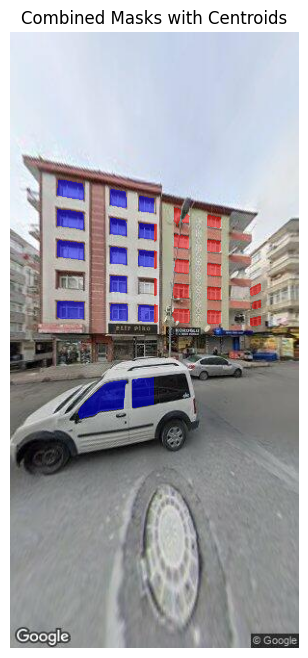

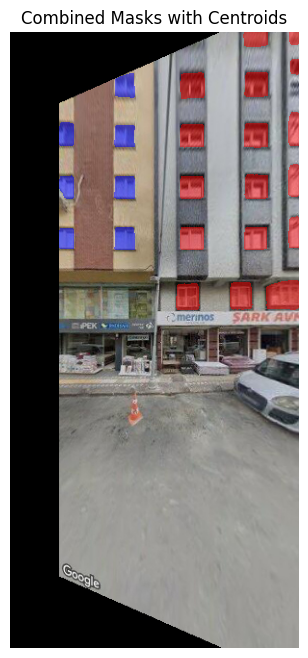

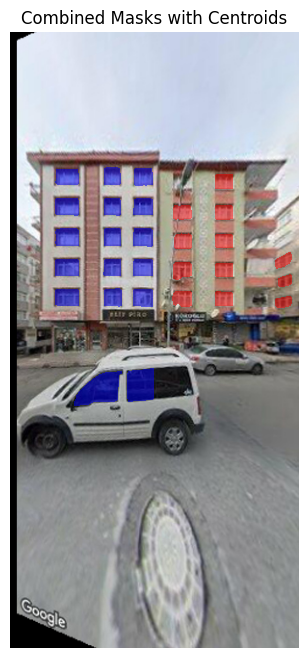

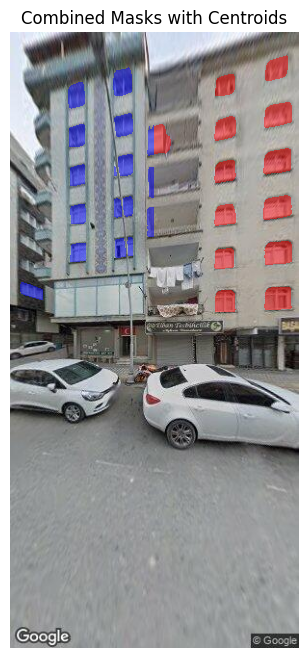

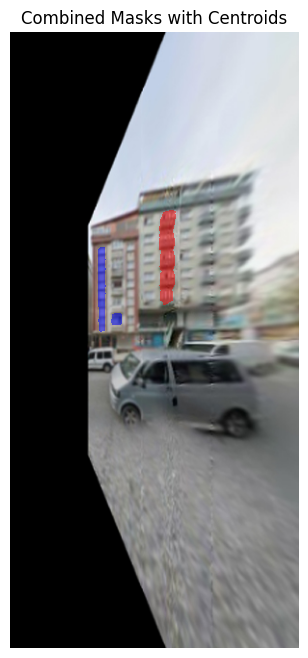

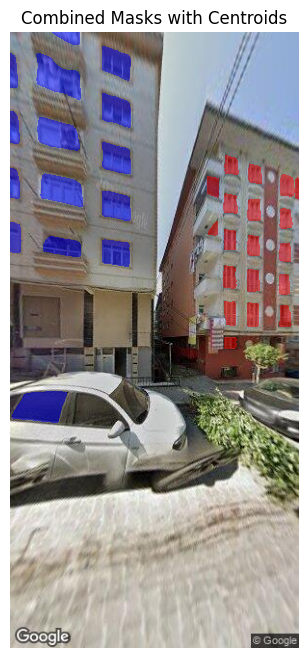

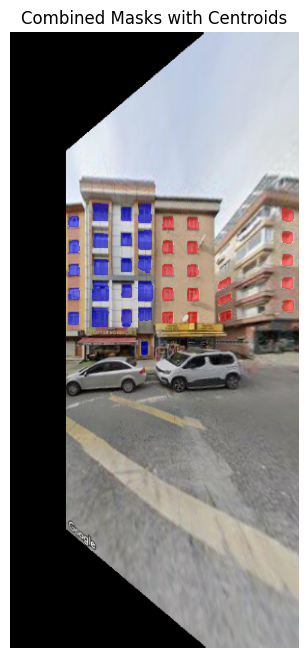

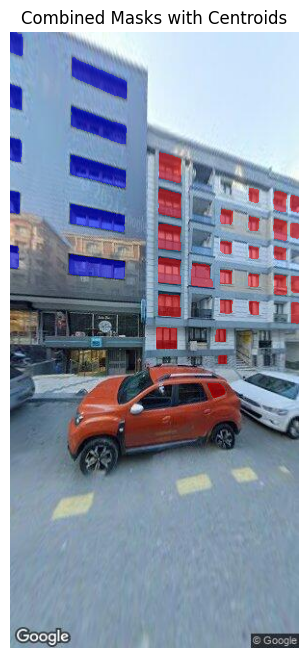

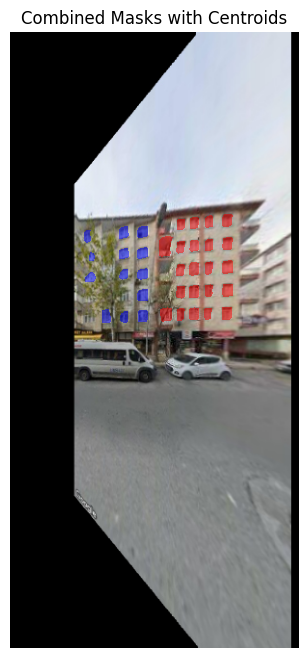

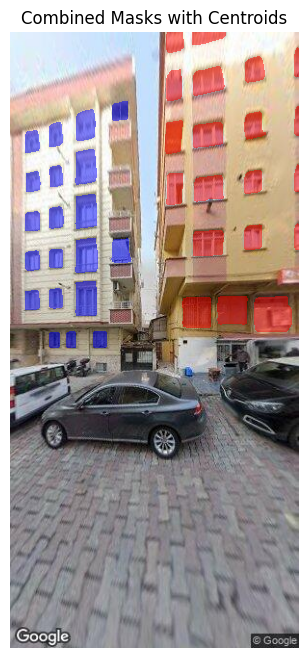

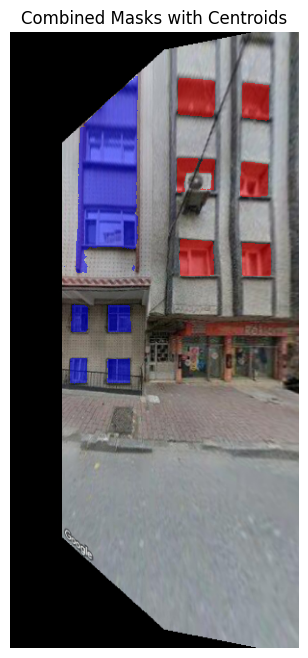

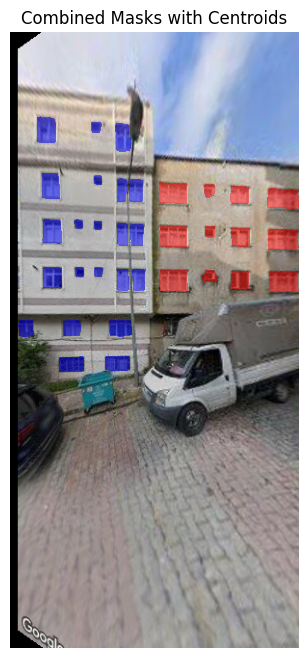

In [ ]:
if __name__ == "__main__":
    main(model)

# 7B. Get building cutouts.

In [ ]:
def main(model):
    # Suppress warning messages
    warnings.filterwarnings("ignore")

    text_prompt = "window"

    folder_path = "/content/drive/MyDrive/FaultLines/svi/40187_size300x800_fov120/svi-20/"

    # List all files and filter by certain image filetypes for processing.
    all_files = os.listdir(folder_path)
    image_extensions = ['.png', '.jpg', '.jpeg']
    image_paths = [os.path.join(folder_path, file) for file in all_files if os.path.splitext(file)[1].lower() in image_extensions]

    for image_path in image_paths:
        process_image(image_path, text_prompt, model)